# ACTIVIDAD EN CLASE

# Evaluando desempeño algoritmos de clustering

Trabajaremos con base en lo desarrollado en clases previas con los datos de: `Medical Insurance`

1. Identificar variables para correr un algoritmo de clustering (no se puede elegir "charges")
2. Elegir algún algoritmo de Clustering (e.g K-Means o clustering Jerárquico) y describir los clusters generados
3. Generar predicciones de clusters para cada observación en el dataset
4. Calcular métricas para evaluar los resultados obtenidos del(los) algoritmo(s) de Clustering

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score, normalized_mutual_info_score, davies_bouldin_score,silhouette_samples


In [315]:
class DataSet:

    def __init__(self):
        self.df = None

    def get_df_from_csv(self, path,sep=","):
        self.df = pd.read_csv(path,sep=sep)
        print("Info del dataset")
        print(self.df.info())

        print("Info sobre distribuciones no categoricas")
        print(self.df.describe().T)
        
        print("\nInfo sobre distribuciones categóricas")
        print(self.df.describe(include=["object", "category"]).T)

        return self

    def clean_data(self,cb:callable):
        return cb(self.df)


In [269]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        # No need to specify columns here as they'll be inferred during transformation
        self.columns = ['sex', 'smoker', 'region']
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        missing_columns = [col for col in self.columns if col not in X.columns]
        if missing_columns:
            raise ValueError(f"Missing columns in input data: {missing_columns}")
        
        X_transformed = X.copy()
        
        # Encode 'sex' and 'smoker' columns to 0/1
        X_transformed['sex'] = (X_transformed['sex'] == 'male').astype(int)
        X_transformed['smoker'] = (X_transformed['smoker'] == 'yes').astype(int)
        
        # One-hot encode 'region' column into dummy variables
        region_dummies = pd.get_dummies(X_transformed['region'], prefix='region')
        X_transformed = pd.concat([X_transformed.drop('region', axis=1), region_dummies], axis=1)
        
        return X_transformed

    

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_select):
        self.features_to_select = features_to_select
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.features_to_select]


class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.feature_names = None
        
    def fit(self, X, y=None):
        self.feature_names = X.columns
        self.scaler.fit(X)
        return self
    
    def transform(self, X):
        scaled_data = self.scaler.transform(X)
        return pd.DataFrame(scaled_data, columns=self.feature_names)
    



class ClusteringEvaluator:
    def __init__(self, X):
        # Ensure X is a pandas DataFrame
        if isinstance(X, np.ndarray):
            self.X = pd.DataFrame(X)  # Convert to DataFrame if it is a numpy array
        else:
            self.X = X

    def evaluate_clustering(self, labels):
        labels = np.array(labels)
        unique_labels = set(labels)
        
        # Handle noise (if all points are noise)
        if len(unique_labels) == 1 and -1 in unique_labels:
            return {
                'silhouette_score': 0,
                'calinski_harabasz_score': 0,
                'adjusted_rand_score': 0,
                'nmi_score': 0,
                'davies_bouldin_score': 0,
                'note': 'All points classified as noise'
            }
        
        mask = labels != -1
        if sum(mask) < 2:
            return {
                'silhouette_score': 0,
                'calinski_harabasz_score': 0,
                'adjusted_rand_score': 0,
                'nmi_score': 0,
                'davies_bouldin_score': 0,
                'note': 'Not enough clustered points for evaluation'
            }

        try:
            return {
                'silhouette_score': round(silhouette_score(self.X[mask], labels[mask]), 3),
                'calinski_harabasz_score': round(calinski_harabasz_score(self.X[mask], labels[mask]), 3),
                'adjusted_rand_score': round(adjusted_rand_score(labels, labels), 3),
                'nmi_score': round(normalized_mutual_info_score(labels, labels), 3),
                'davies_bouldin_score': round(davies_bouldin_score(self.X[mask], labels[mask]), 3)
            }
        except Exception as e:
            return {
                'silhouette_score': 0,
                'calinski_harabasz_score': 0,
                'adjusted_rand_score': 0,
                'nmi_score': 0,
                'davies_bouldin_score': 0,
                'note': f'Error calculating scores: {str(e)}'
            }

    def evaluate_for_n_clusters(self, range_n_clusters, clustering_algorithm):
        """
        Evaluates clustering for different values of n_clusters.

        :param range_n_clusters: List of different values of n_clusters to evaluate.
        :param clustering_algorithm: Clustering algorithm (e.g., KMeans, AgglomerativeClustering) to evaluate.
        :return: DataFrame with evaluation metrics for each number of clusters.
        """
        metrics_list = []
        
        for n_clusters in range_n_clusters:
            # Set n_clusters parameter for the clustering step of the pipeline
            clustering_algorithm.set_params(n_clusters=n_clusters)
            
            # Fit the clustering model and get labels
            labels = clustering_algorithm.fit_predict(self.X)
            
            # Evaluate the clustering result
            metrics = self.evaluate_clustering(labels)
            metrics_list.append({
                'n_clusters': n_clusters,
                'silhouette_score': metrics['silhouette_score'],
                'calinski_harabasz_score': metrics['calinski_harabasz_score'],
                'adjusted_rand_score': metrics['adjusted_rand_score'],
                'nmi_score': metrics['nmi_score'],
                'davies_bouldin_score': metrics['davies_bouldin_score']
            })
        
        # Convert list of dictionaries to DataFrame
        metrics_df = pd.DataFrame(metrics_list)
        return metrics_df
    



In [316]:
csv_path:str = "./csv/insurance.csv"
dataset = DataSet().get_df_from_csv(path=csv_path)

Info del dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
Info sobre distribuciones no categoricas
           count          mean           std        min         25%       50%  \
age       1338.0     39.207025     14.049960    18.0000    27.00000    39.000   
bmi       1338.0     30.663397      6.098187    15.9600    26.29625    30.400   
children  1338.0      1.094918      1.205493     0.0000     0.00000     1.000   
charges   1338.0  13270.422265  12110.011237  1121.8739  4740.28715  9382.033   

           

In [271]:
# Create clustering pipelines
preprocessor = Pipeline([
    ('categorical_encoder', CategoricalEncoder()),
    ('feature_selector', FeatureSelector(

)),        ['age', 'sex', 'bmi', 'children', 'smoker', 
         'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
    ('scaler', StandardScaler())
])

X_transformed = preprocessor.fit_transform(dataset.df)

In [272]:
# Create clustering pipelines
def create_clustering_pipeline(clustering_algorithm): 
    return Pipeline([
        ('categorical_encoder', CategoricalEncoder()),
        ('feature_selector', FeatureSelector(
            ['age', 'sex', 'bmi', 'children', 'smoker', 
             'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
        )),
        ('scaler', StandardScaler()),
        ('clustering', clustering_algorithm)
    ])

In [273]:
n_clusters_list = [2, 3, 4, 5, 6]
# Create clustering algorithms with desired number of clusters
kmeans = KMeans(n_clusters=n_clusters_list[2], random_state=42)
hierarchical = AgglomerativeClustering(n_clusters=n_clusters_list[2])


In [274]:
# Create pipelines for each clustering algorithm
kmeans_pipeline = create_clustering_pipeline(kmeans)
hierarchical_pipeline = create_clustering_pipeline(hierarchical)


In [275]:
evaluator = ClusteringEvaluator(X_transformed)

In [276]:
# Evaluate for KMeans
metrics_df_kmeans = evaluator.evaluate_for_n_clusters(n_clusters_list, kmeans)
print("KMeans Clustering Evaluation:")
metrics_df_kmeans


KMeans Clustering Evaluation:


,n_clusters,silhouette_score,calinski_harabasz_score,adjusted_rand_score,nmi_score,davies_bouldin_score
0,2,0.117,150.299,1.0,1.0,2.938
1,3,0.206,243.379,1.0,1.0,2.062
2,4,0.332,370.268,1.0,1.0,1.318
3,5,0.288,314.131,1.0,1.0,1.546
4,6,0.268,275.917,1.0,1.0,1.507


In [277]:
# Evaluate for Agglomerative Clustering
metrics_df_hierarchical = evaluator.evaluate_for_n_clusters(n_clusters_list, hierarchical)
print("Hierarchical Clustering Evaluation:")
metrics_df_hierarchical

Hierarchical Clustering Evaluation:


,n_clusters,silhouette_score,calinski_harabasz_score,adjusted_rand_score,nmi_score,davies_bouldin_score
0,2,0.176,254.009,1.0,1.0,1.892
1,3,0.251,296.401,1.0,1.0,1.704
2,4,0.332,370.268,1.0,1.0,1.318
3,5,0.303,319.563,1.0,1.0,1.401
4,6,0.294,284.971,1.0,1.0,1.453


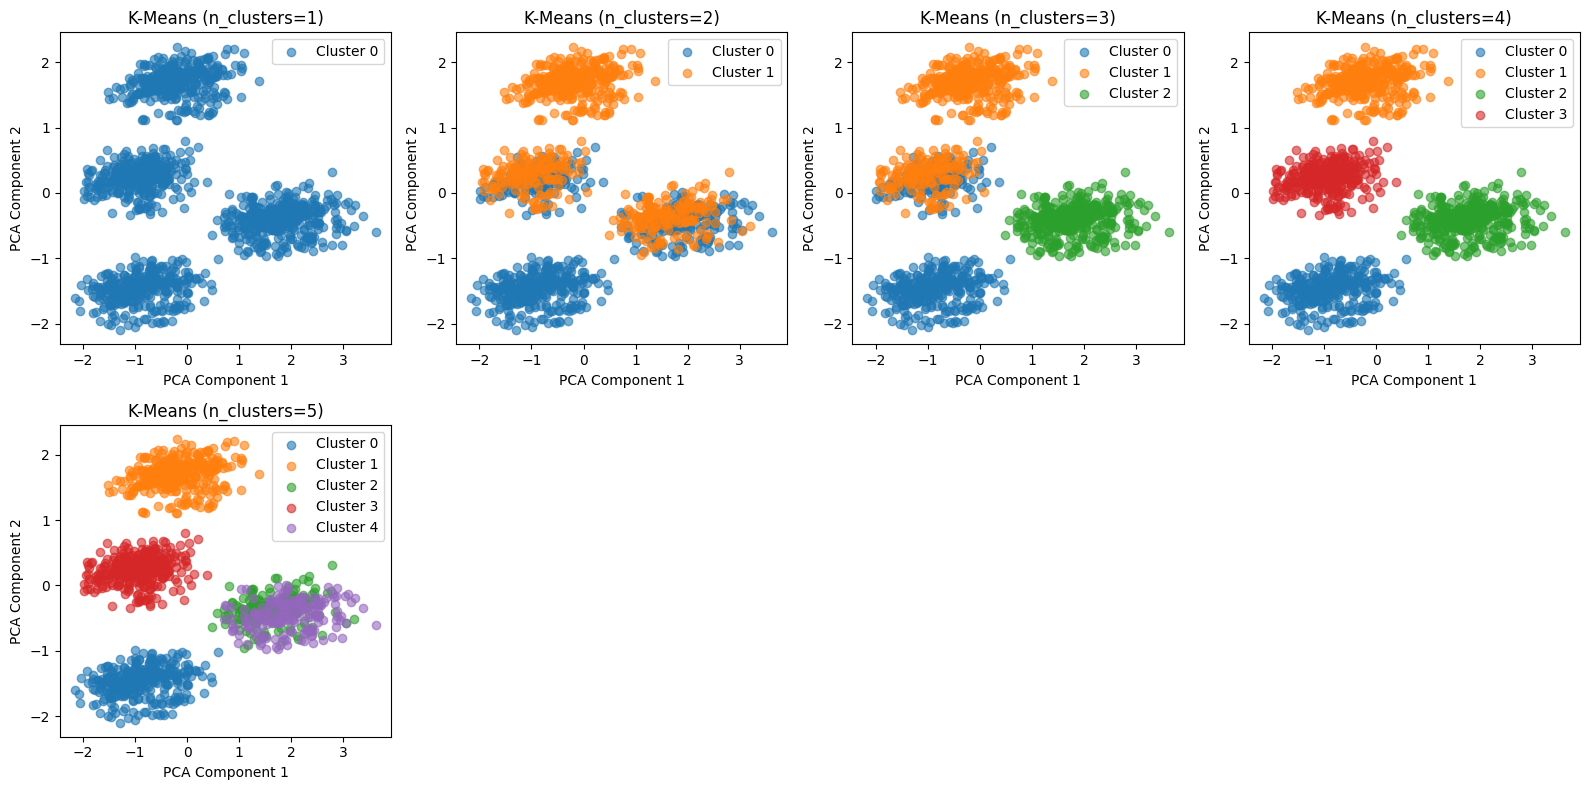

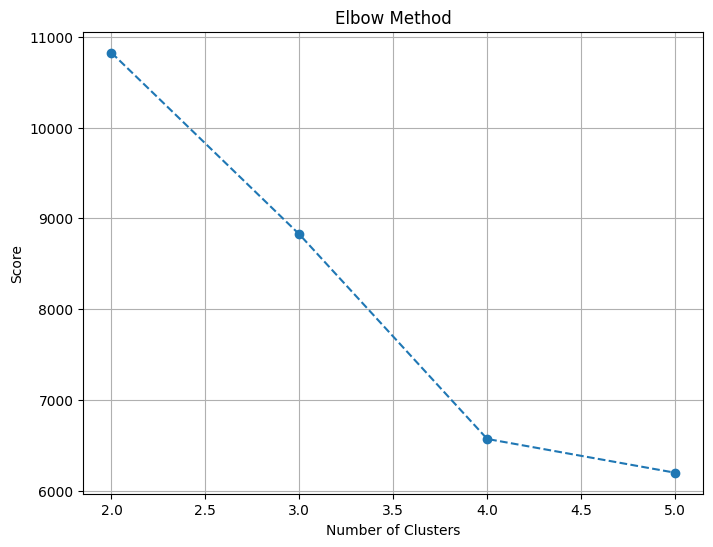

For n_clusters = 2, the average silhouette score is 0.12


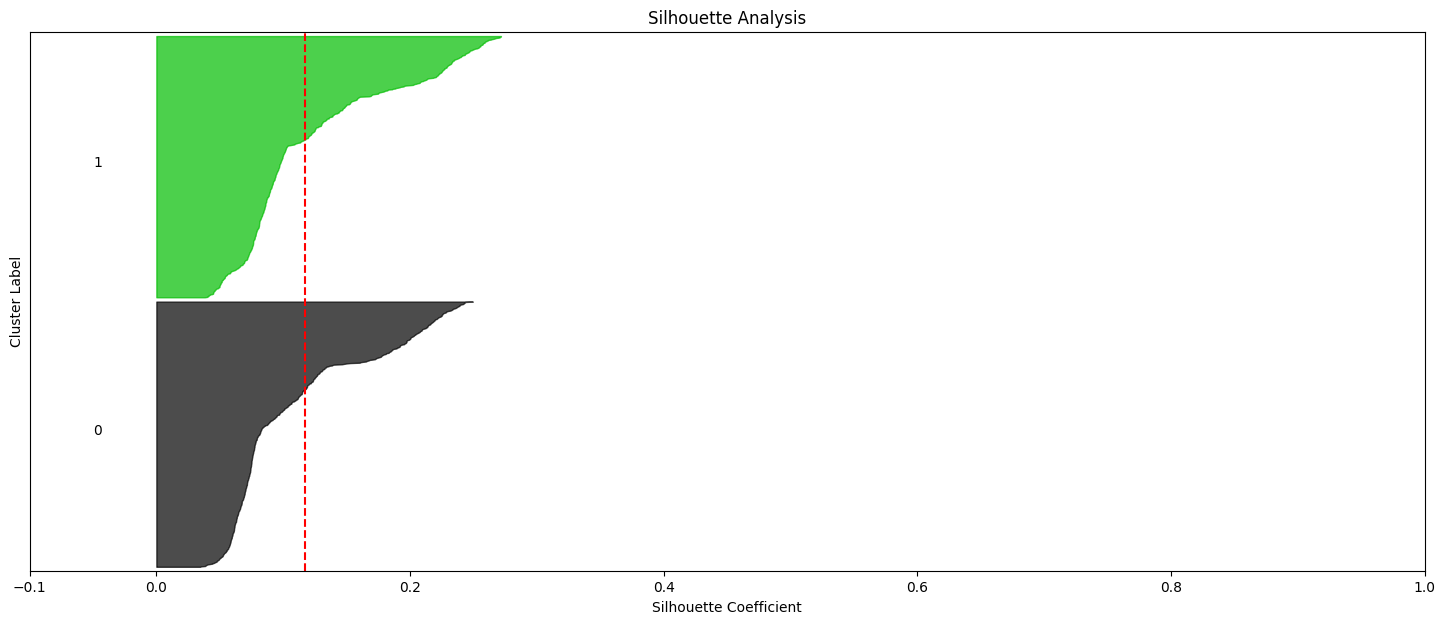

For n_clusters = 3, the average silhouette score is 0.21


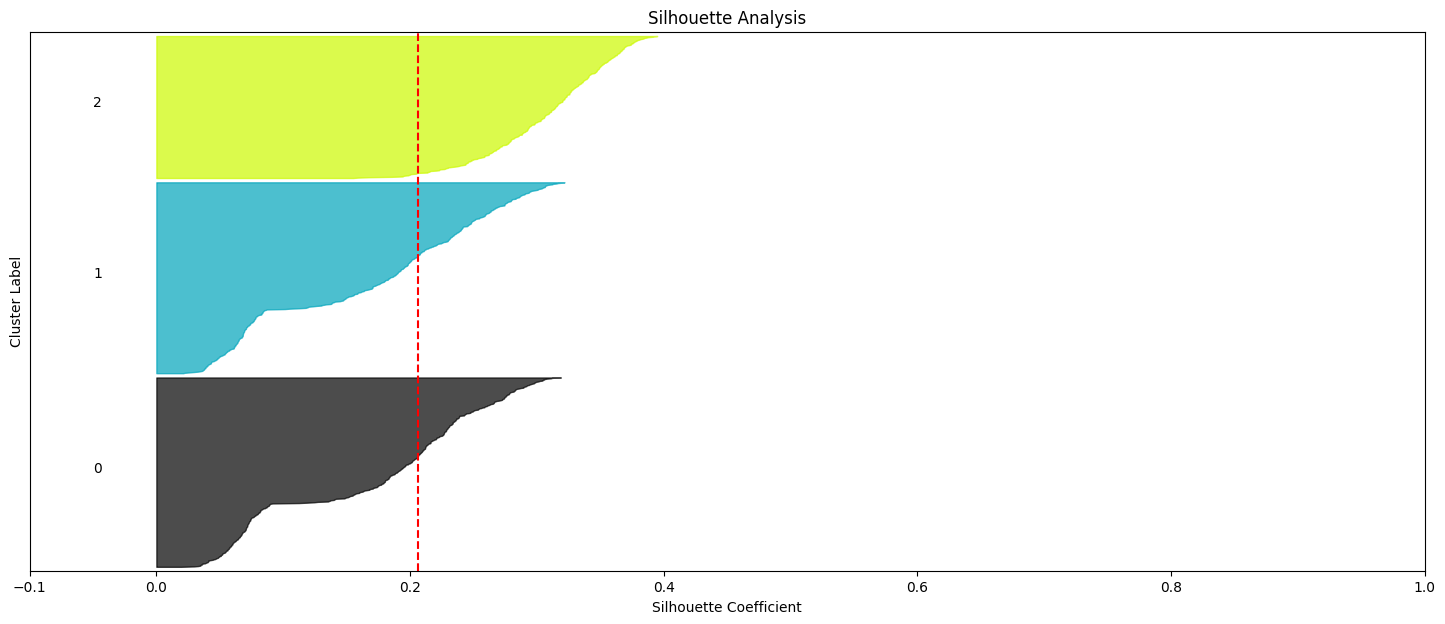

For n_clusters = 4, the average silhouette score is 0.33


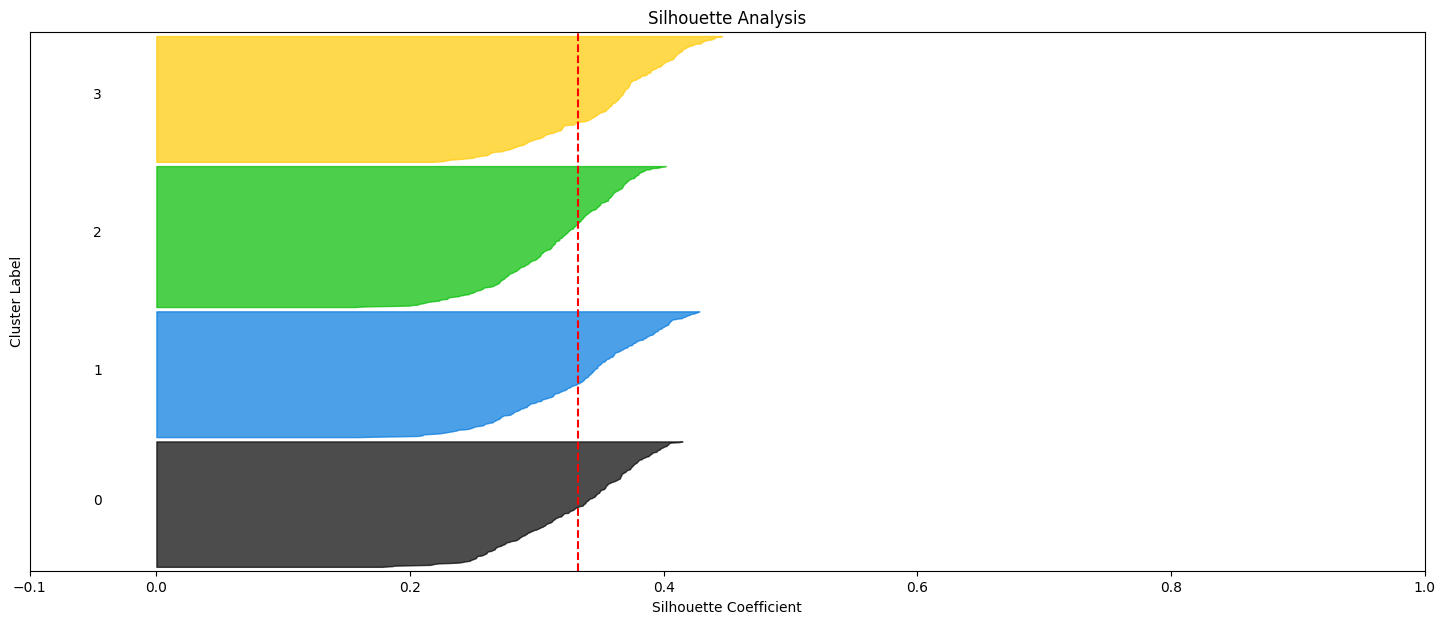

For n_clusters = 5, the average silhouette score is 0.29


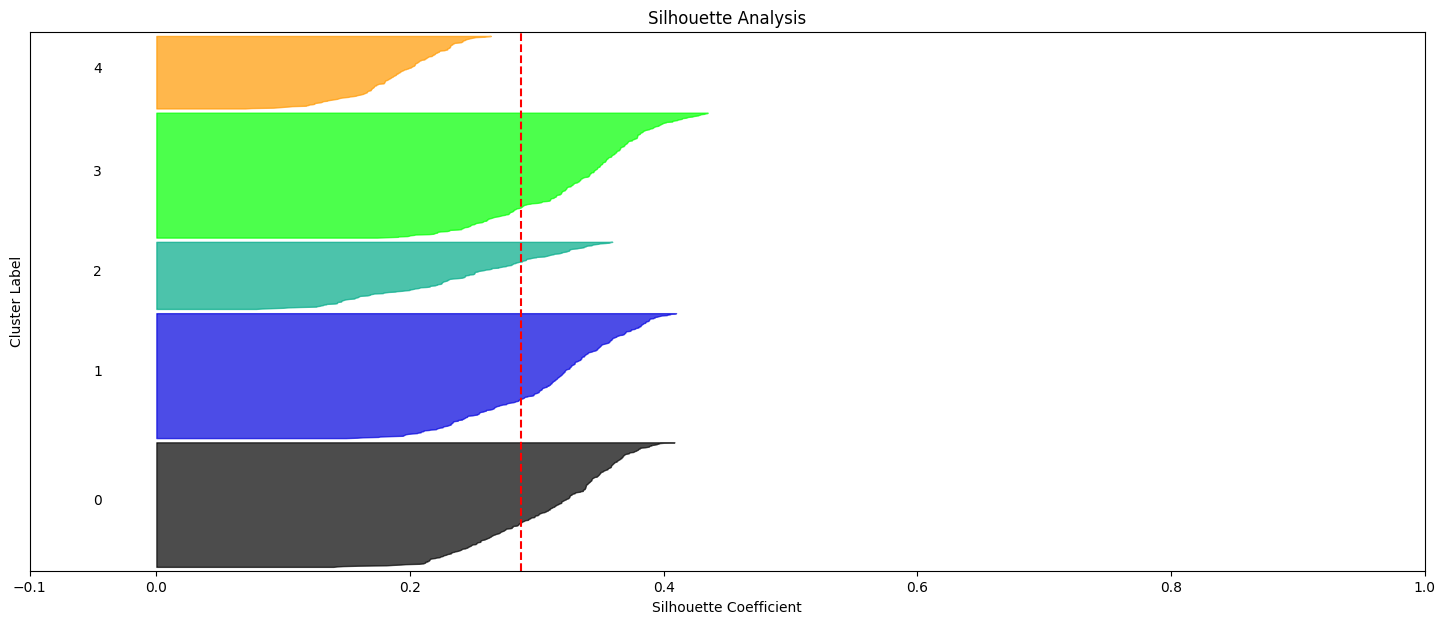

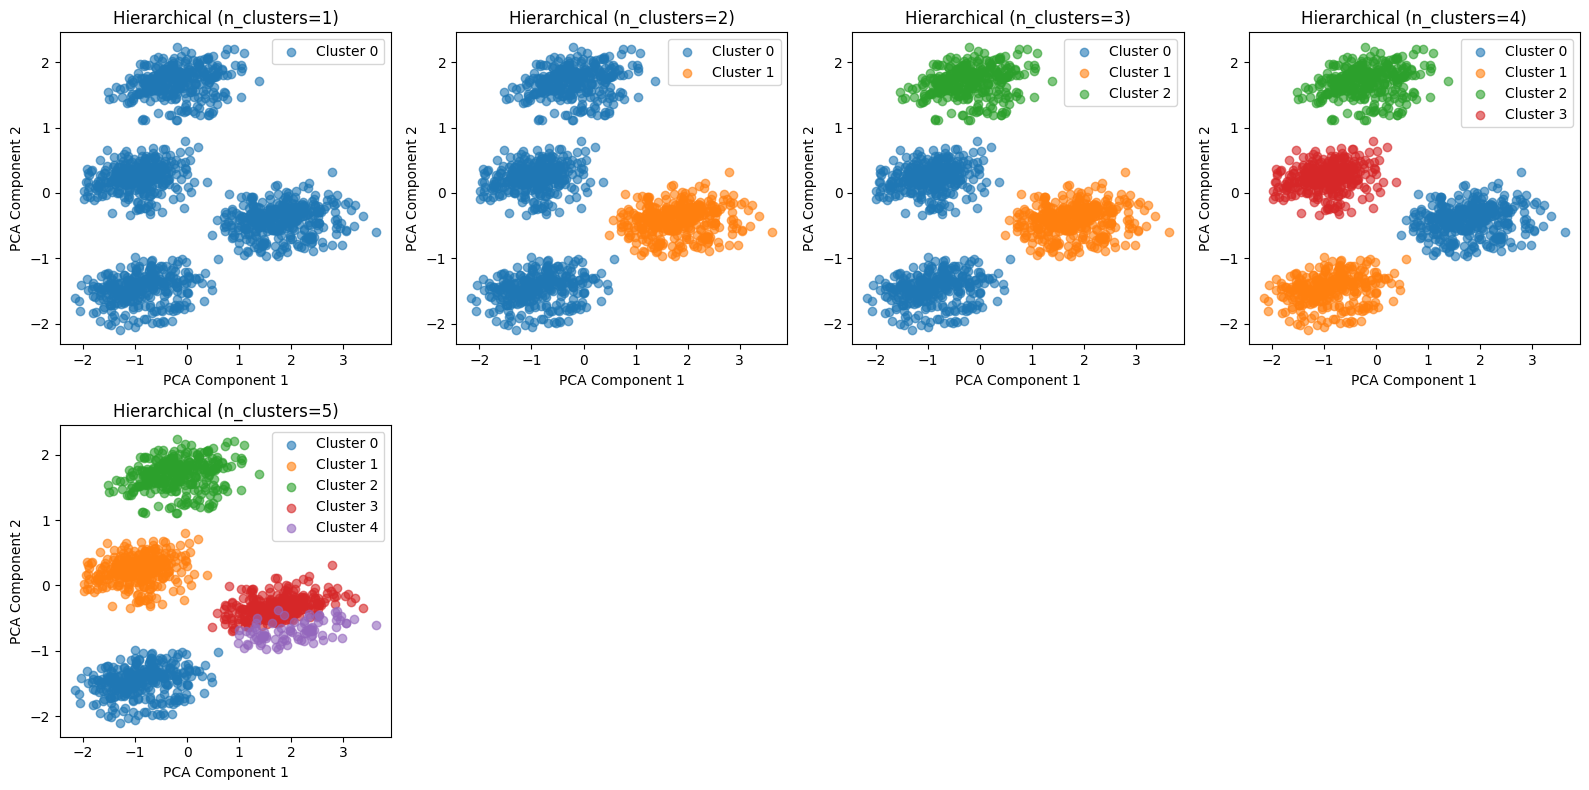

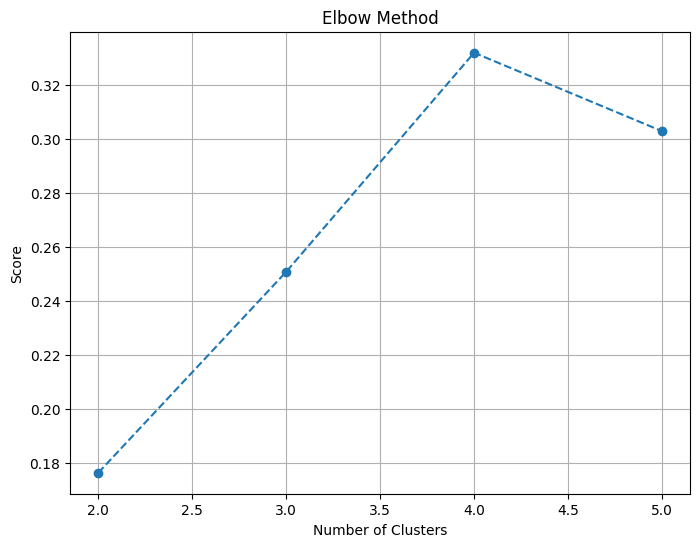

For n_clusters = 2, the average silhouette score is 0.18


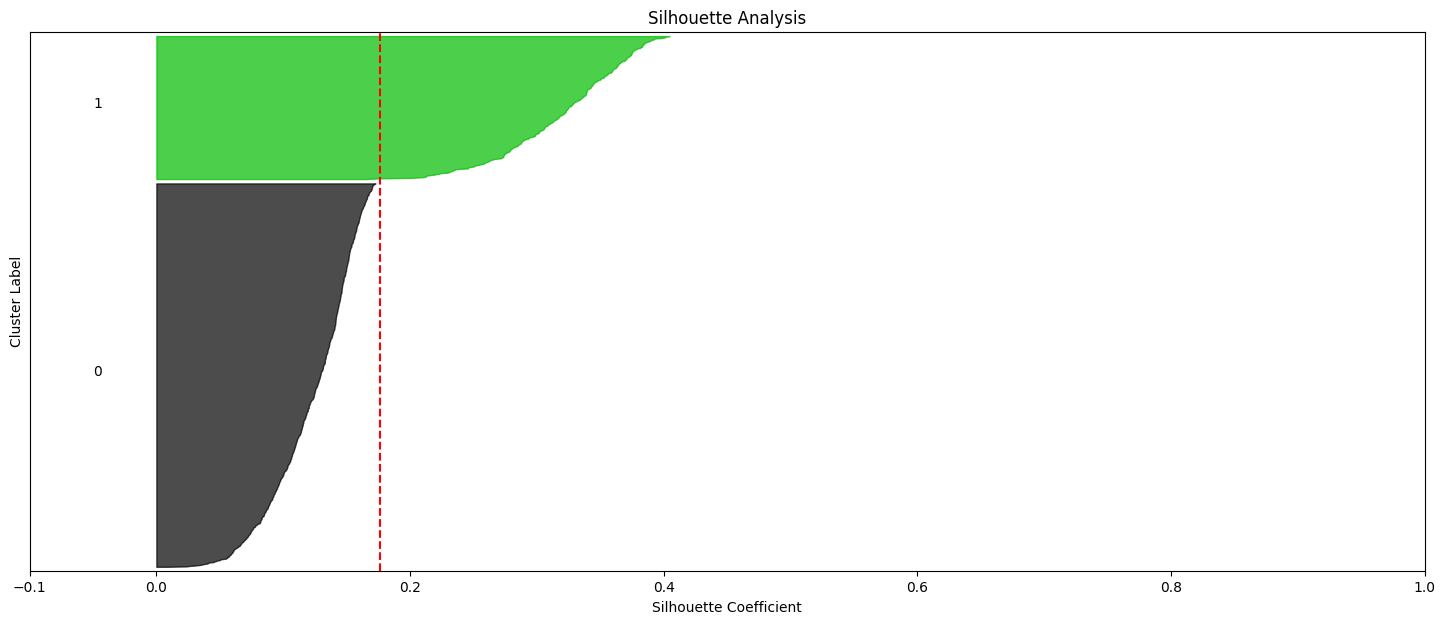

For n_clusters = 3, the average silhouette score is 0.25


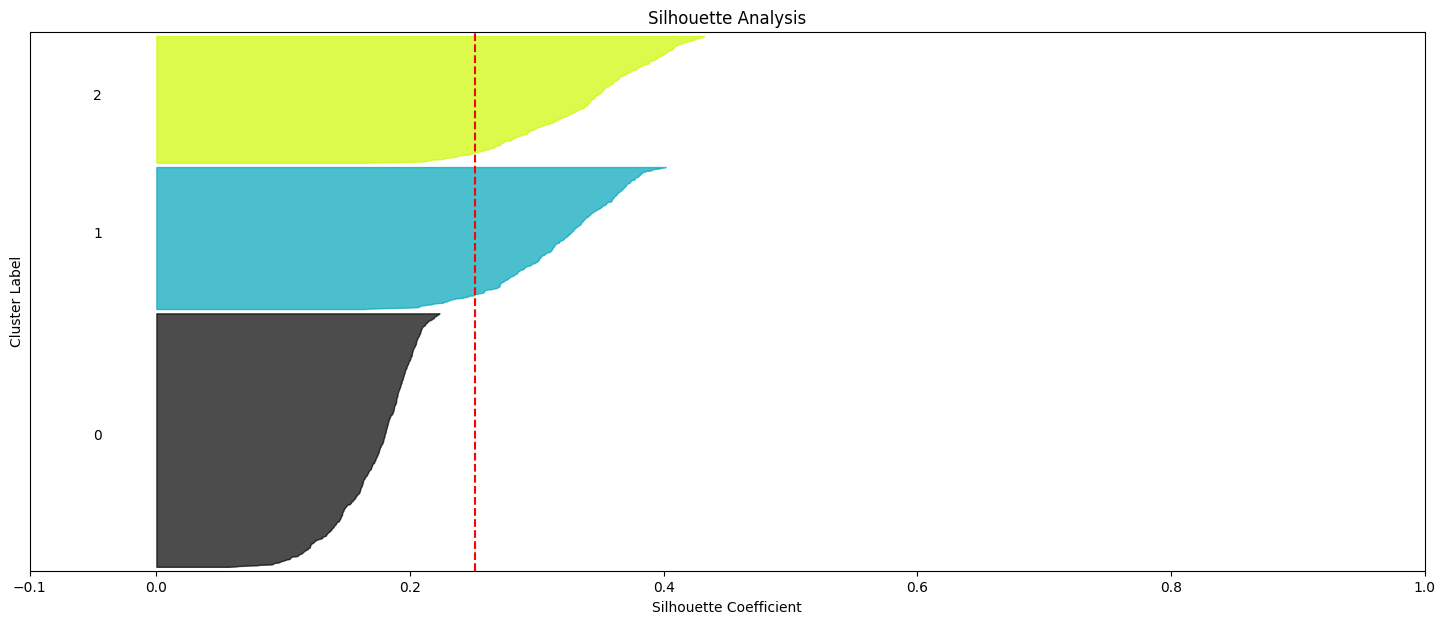

For n_clusters = 4, the average silhouette score is 0.33


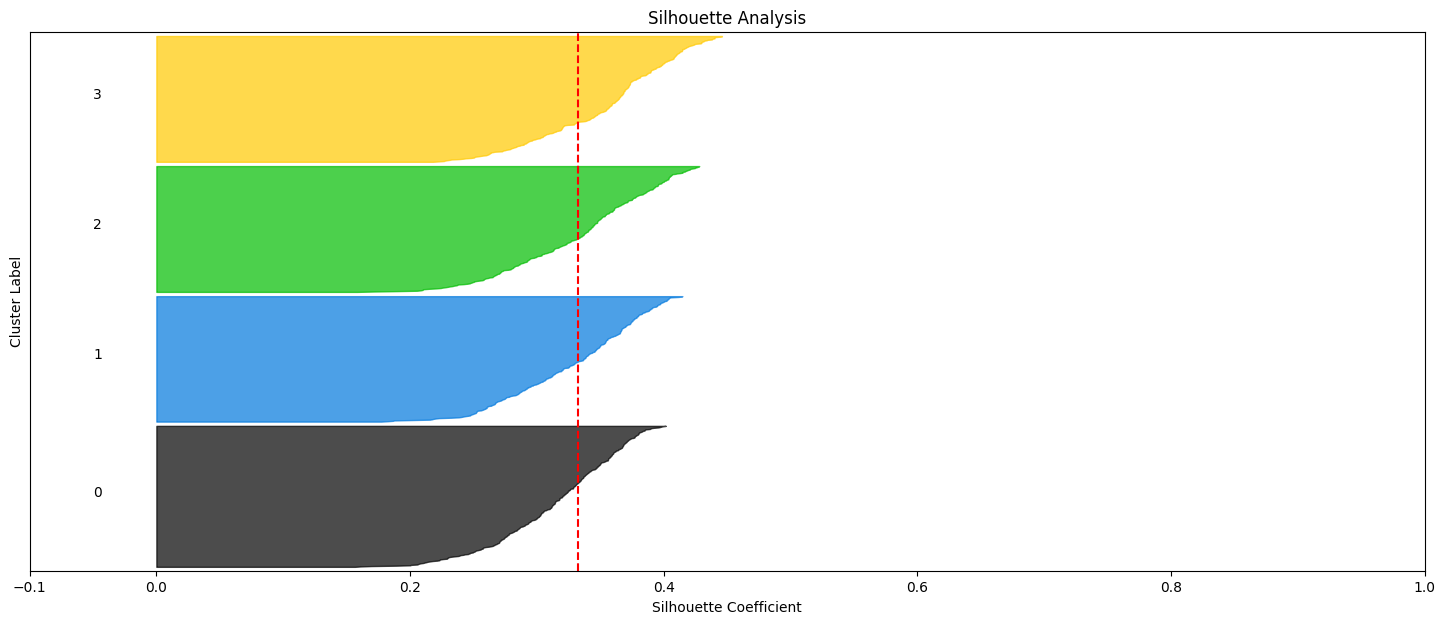

For n_clusters = 5, the average silhouette score is 0.30


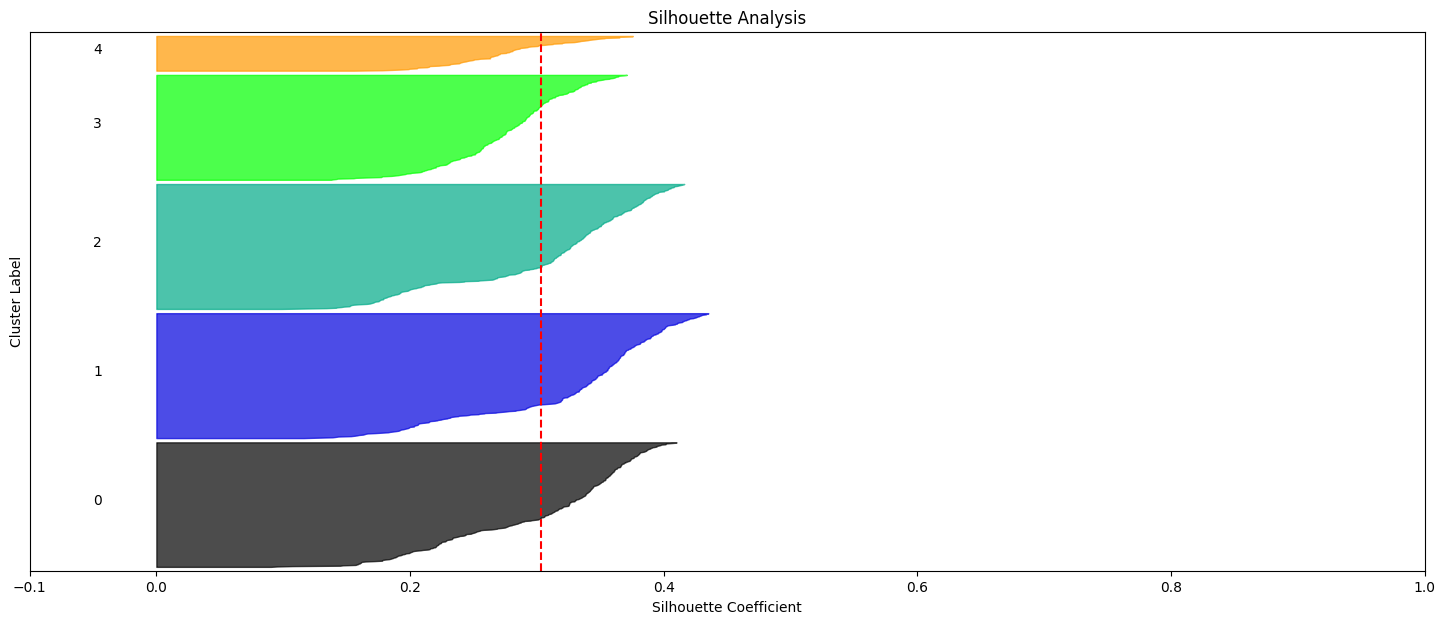

In [313]:
import math
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

class PreProcessor:
    preprocessor = Pipeline([
        ('categorical_encoder', CategoricalEncoder()),
        ('feature_selector', FeatureSelector(
            ['age', 'sex', 'bmi', 'children', 'smoker', 
            'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
        )),
        ('scaler', StandardScaler())
    ])

    def get_processor(self):
        return self.preprocessor


class ClusterPlotter:
    def __init__(self, dataframe, clustering_algorithm, max_cols=4):
        self.dataframe = dataframe
        self.preprocessor = PreProcessor().get_processor()
        self.clustering_algorithm = clustering_algorithm
        self.max_cols = max_cols
        self.X_transformed = self.preprocessor.fit_transform(self.dataframe)

    def _plot_clusters(self, labels, title, ax):
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(self.X_transformed)
        
        unique_labels = set(labels)
        for label in unique_labels:
            mask = labels == label
            cluster_points = X_2d[mask]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                       label=f'Cluster {label}' if label != -1 else 'Noise', alpha=0.6)

        ax.set_title(title)
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.legend()

    def plot(self, name, n_clusters_list):
        n_clusters = len(n_clusters_list)
        n_rows = math.ceil(n_clusters / self.max_cols)
        
        fig, axes = plt.subplots(n_rows, self.max_cols, figsize=(self.max_cols * 4, n_rows * 4))
        axes = axes.flatten()

        for i, n_clusters in enumerate(n_clusters_list):
            self.clustering_algorithm.set_params(clustering__n_clusters=n_clusters)
            labels = self.clustering_algorithm.fit_predict(self.dataframe)
            self._plot_clusters(labels, f"{name} (n_clusters={n_clusters})", axes[i])

        for j in range(len(n_clusters_list), len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()

    def plot_elbow(self, n_clusters_list):
        """
        Plot the elbow method to identify the optimal number of clusters.

        :param n_clusters_list: List of n_clusters values to evaluate.
        """
        scores = []

        for n_clusters in n_clusters_list:
            # Skip n_clusters = 1 since silhouette_score requires at least 2 clusters
            if n_clusters == 1:
                scores.append(None)  # Placeholder for invalid silhouette score
                continue

            # Set the n_clusters parameter for the clustering algorithm
            self.clustering_algorithm.set_params(clustering__n_clusters=n_clusters)
            
            # Fit the clustering algorithm and get labels
            labels = self.clustering_algorithm.fit_predict(self.dataframe)
            
            if hasattr(self.clustering_algorithm.named_steps['clustering'], 'inertia_'):
                # Use inertia for KMeans
                scores.append(self.clustering_algorithm.named_steps['clustering'].inertia_)
            else:
                # Use silhouette score for other algorithms
                score = silhouette_score(self.X_transformed, labels)
                scores.append(score)

        # Replace None with NaN for better plotting
        scores = [score if score is not None else float('nan') for score in scores]

        # Plot the elbow curve
        plt.figure(figsize=(8, 6))
        plt.plot(n_clusters_list, scores, marker='o', linestyle='--')
        plt.title("Elbow Method")
        plt.xlabel("Number of Clusters")
        plt.ylabel("Score")
        plt.grid(True)
        plt.show()

    def plot_silhouette(self, n_clusters_list):
        # Filter n_clusters_list to exclude 1
        valid_clusters_list = [n for n in n_clusters_list if n > 1]

        X = pd.DataFrame(self.X_transformed, columns=['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest'])

        for n_clusters in valid_clusters_list:
            fig, (ax1) = plt.subplots(1)
            fig.set_size_inches(18, 7)

            ax1.set_xlim([-0.1, 1])
            ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

            # Set the number of clusters in the clustering algorithm
            clusterer = self.clustering_algorithm.set_params(clustering__n_clusters=n_clusters)
            cluster_labels = clusterer.fit_predict(self.dataframe)

            silhouette_avg = silhouette_score(X, cluster_labels)

            print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg:.2f}")

            sample_silhouette_values = silhouette_samples(X, cluster_labels)
            y_lower = 10

            for i in range(n_clusters):
                ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
                ith_cluster_silhouette_values.sort()
                size_cluster_i = ith_cluster_silhouette_values.shape[0]
                y_upper = y_lower + size_cluster_i

                color = cm.nipy_spectral(float(i) / n_clusters)
                ax1.fill_betweenx(np.arange(y_lower, y_upper),
                                0, ith_cluster_silhouette_values,
                                facecolor=color, edgecolor=color, alpha=0.7)
                ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
                y_lower = y_upper + 10

            ax1.set_title("Silhouette Analysis")
            ax1.set_xlabel("Silhouette Coefficient")
            ax1.set_ylabel("Cluster Label")
            ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
            ax1.set_yticks([])
            ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

            plt.show()



for name, cluster_pipe in [
    ("K-Means", kmeans_pipeline),
    ("Hierarchical", hierarchical_pipeline),
]:
    plotter = ClusterPlotter(dataset.df, cluster_pipe)
    plotter.plot(name, n_clusters_list=range(1,6))
    plotter.plot_elbow(n_clusters_list=range(1,6))
    plotter.plot_silhouette(n_clusters_list=range(1,6))


